<a href="https://colab.research.google.com/github/kadhichawal/Pneumonia_Detection/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle fastai torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.2 MB/s eta 0:00:00


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ishandahiya29","key":"774335ad5542569ce3413a852eeb8fce"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:32<00:00, 55.7MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.2MB/s]


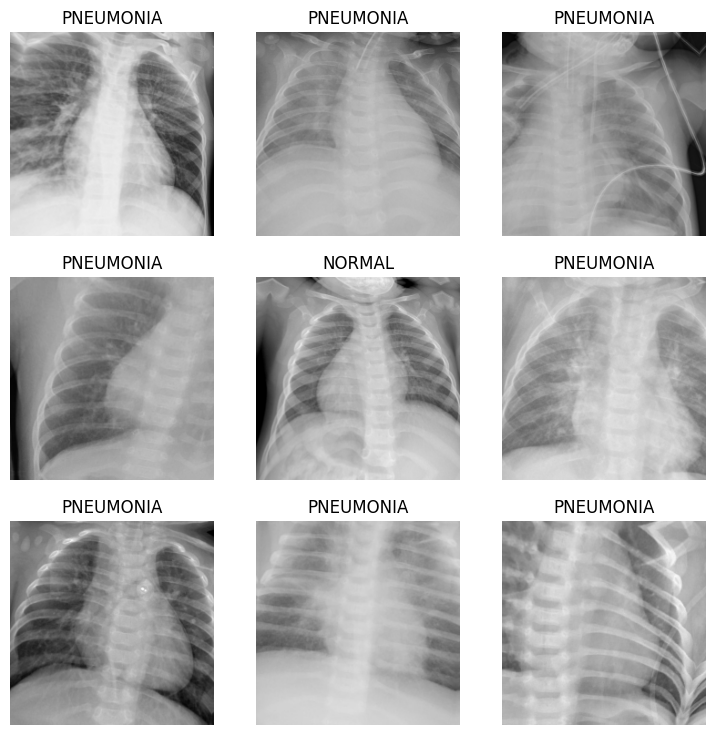

In [8]:
from fastai.vision.all import *

# Define paths
path = Path('/content/chest_xray')
train_path = path/'train'
test_path = path/'test'

# CORRECTED DataLoaders creation
dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(460),
    batch_tfms=[
        *aug_transforms(size=224),  # Augmentations
        Normalize.from_stats(*imagenet_stats)  # Normalization
    ]
)
dls.show_batch()

In [9]:
# Initialize ResNet50 model
learn = cnn_learner(
    dls,
    models.resnet50,
    metrics=[accuracy, F1Score()]
)

# Train for 10 epochs
learn.fine_tune(10, freeze_epochs=3)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.601704,0.293524,0.905082,0.933153,01:58
1,0.366343,0.306739,0.930968,0.951872,02:03
2,0.273492,0.263631,0.940556,0.958722,02:02


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.217953,0.217016,0.950144,0.965426,02:06
1,0.162135,0.142517,0.957814,0.971091,02:06
2,0.122373,0.127997,0.966443,0.976989,02:05
3,0.112684,0.142010,0.958773,0.971692,02:05
4,0.092230,0.175193,0.953979,0.968000,02:05
5,0.074880,0.107698,0.965484,0.976378,02:05
6,0.067614,0.106991,0.971237,0.980237,02:05
7,0.064182,0.096468,0.973154,0.981699,02:05
8,0.058225,0.102316,0.971237,0.980341,02:04
9,0.057637,0.116734,0.965484,0.976285,02:05


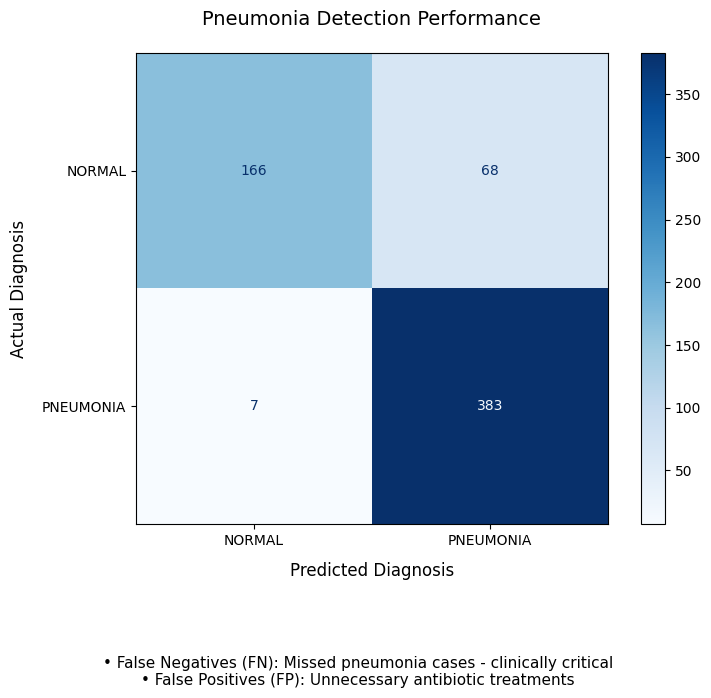

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Get class names from original DataLoaders
class_names = dls.vocab  # ['NORMAL', 'PNEUMONIA']

# 2. Convert predictions to class indices
pred_labels = preds.argmax(dim=1).numpy()
true_labels = targs.numpy()

# 3. Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# 4. Plot with medical context
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
).plot(ax=ax, cmap='Blues', values_format='d')

# 5. Add medical analysis annotations
plt.title('Pneumonia Detection Performance', fontsize=14, pad=20)
plt.xlabel('Predicted Diagnosis', fontsize=12, labelpad=10)
plt.ylabel('Actual Diagnosis', fontsize=12, labelpad=10)

# 6. Highlight critical medical metrics
'''
for i in range(2):
    for j in range(2):
        color = "white" if i==j else ("red" if (i==0 and j==1) else "darkorange")
        weight = "bold" if i!=j else "normal"
        ax.text(j, i, f"{cm[i, j]}",
                ha='center', va='center',
                color=color, fontsize=14, fontweight=weight)
'''
# 7. Add clinical interpretation
plt.figtext(0.5, -0.15,
    "• False Negatives (FN): Missed pneumonia cases - clinically critical\n"
    "• False Positives (FP): Unnecessary antibiotic treatments",
    ha="center", fontsize=11
)

plt.tight_layout()
plt.show()


Test directory contents: [Path('/content/chest_xray/test/PNEUMONIA'), Path('/content/chest_xray/test/NORMAL')]



Diagnosis for person78_bacteria_380.jpeg:
• Prediction: PNEUMONIA
• Pneumonia probability: 99.50%
• Normal probability: 0.50%


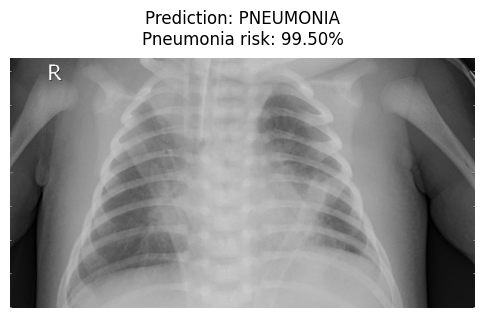

In [19]:
# Step 7: Make Predictions (Fixed Version)

# 1. Verify test directory structure
test_path = path/'test'
print(f"Test directory contents: {list(test_path.glob('*'))}")

# 2. Find first available pneumonia image
pneumonia_images = list((test_path/'PNEUMONIA').glob('*.jpeg*'))
if not pneumonia_images:
    # Fallback to any test image
    all_test_images = get_image_files(test_path)
    if all_test_images:
        img_path = all_test_images[0]
        print(f"⚠️ Using fallback image: {img_path}")
    else:
        raise FileNotFoundError("No test images found! Re-check dataset download")
else:
    img_path = pneumonia_images[0]

# 3. Load and predict
img = PILImage.create(img_path)
pred, _, probs = learn.predict(img)

# 4. Output with clinical context
print(f"\nDiagnosis for {img_path.name}:")
print(f"• Prediction: {pred}")
print(f"• Pneumonia probability: {probs[1].item():.2%}")
print(f"• Normal probability: {probs[0].item():.2%}")

# 5. Visualize
img.show(figsize=(6,6))
plt.title(f"Prediction: {pred}\nPneumonia risk: {probs[1].item():.2%}",
          fontsize=12, pad=10)
plt.axis('off')
plt.show()



In [21]:
# Step 1: Save model
learn.export('/content/pneumonia_model.pkl')

# Step 2: Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Copy to Drive
!cp /content/pneumonia_model.pkl /content/drive/MyDrive/

# Step 4: Verify (critical for medical models)
import os

# Check source
src = '/content/pneumonia_model.pkl'
print(f"Source exists: {os.path.isfile(src)} ({os.path.getsize(src)/1e6:.1f} MB)")

# Check destination
dest = '/content/drive/MyDrive/pneumonia_model.pkl'
print(f"Destination exists: {os.path.isfile(dest)}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Source exists: True (103.0 MB)
Destination exists: True
